# ML for breathing

Applying simple, common machine learning models to segments of EMG to predict whether segment was with our without respiratory muscle effort i.e. whether we are looking at a patient created breath.

## Import libraries

In [9]:
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
import collections
from collections import namedtuple
import builtins
import math
from scipy.stats import entropy

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.metrics import confusion_matrix

In [11]:
# import sys
# !{sys.executable} -m pip install seaborn

In [12]:
import seaborn

## Import and set up data ( see ML_snippet_maker notebook for generation)

In [13]:

csv = pd.read_csv('../researcher_interface/ML_files/for_ml_csv.csv')
csv2 = pd.read_csv('../researcher_interface/ML_files/for_ml_csv2.csv')

In [14]:
csv2.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,991,992,993,994,995,996,997,998,999,label
0,0,0.000059,0.000055,0.000044,0.000039,0.000170,0.000218,0.000110,0.000061,0.000186,...,0.000021,0.000042,5.928041e-05,0.000069,0.000038,0.000040,0.000102,1.012105e-04,0.000054,exhale
1,1,0.000184,0.000016,0.000167,0.000237,0.000167,0.000027,0.000084,0.000080,0.000046,...,0.000036,0.000035,6.349561e-05,0.000040,0.000021,0.000079,0.000079,2.753498e-05,0.000024,exhale
2,2,0.000040,0.000155,0.000183,0.000081,0.000122,0.000079,0.000111,0.000013,0.000076,...,0.000104,0.000251,2.212753e-04,0.000087,0.000023,0.000048,0.000020,2.833529e-07,0.000018,exhale
3,3,0.000130,0.000068,0.000023,0.000010,0.000072,0.000043,0.000043,0.000044,0.000068,...,0.000092,0.000077,4.719800e-08,0.000100,0.000139,0.000062,0.000064,1.051652e-04,0.000033,exhale
4,4,0.000212,0.000112,0.000047,0.000122,0.000386,0.000544,0.000385,0.000042,0.000408,...,0.000039,0.000111,7.080898e-05,0.000034,0.000106,0.000104,0.000042,3.894382e-05,0.000074,exhale


In [17]:
csv = csv.dropna()
csv2 = csv2.dropna()

In [48]:
#len(csv2)

In [20]:
listicle = (list(range(999)))
fu = list(map(str, listicle))

We are going to add some random values for sanity checking... ML based on random values should give us an accuracy approaching 0.5 in this case.

In [21]:
csv2['std'] = csv2[fu].std(axis=1)
csv2['max'] = csv2[fu].max(axis=1)
csv2['min'] = csv2[fu].min(axis=1)
csv2['mean'] = csv2[fu].mean(axis=1)
csv2['entropy'] = csv2[fu].apply(entropy, axis=1)
csv2['random1'] = csv2.apply(lambda x: np.random.randint(0,100-x['1'],1)[0], axis=1)
csv2['random2'] = csv2.apply(lambda x: np.random.randint(0,100-x['2'],1)[0], axis=1)


In [22]:
csv['std'] = csv[fu].std(axis=1)
csv['max'] = csv[fu].max(axis=1)
csv['min'] = csv[fu].min(axis=1)
csv['mean'] = csv[fu].mean(axis=1)
csv['entropy'] = csv[fu].apply(entropy, axis =1)
csv['random1'] = csv.apply(lambda x: np.random.randint(0,100-x['1'],1)[0], axis=1)
csv['random2'] = csv.apply(lambda x: np.random.randint(0,100-x['2'],1)[0], axis=1)

In [23]:
csv.loc[csv['label']== 'exhale', 'label'] = 0
csv.loc[csv['label']== 'inhale', 'label'] = 1
csv2.loc[csv2['label']== 'exhale', 'label'] = 0
csv2.loc[csv2['label']== 'inhale', 'label'] = 1

In [24]:
csv_to = pd.concat([csv,csv2])

Now we have a data frame of the raw data (columns 0:999) from a bunch of EMG snippets (the rows) , and some features of them e.g. maximum value, mean etc.

In [26]:
len(csv_to)

105

In [27]:
csv_to.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,998,999,label,std,max,min,mean,entropy,random1,random2
0,0,0.000270,0.000127,0.000186,0.000341,0.000163,0.000243,0.000087,0.000149,0.000038,...,0.000025,0.000139,0,0.000098,0.000610,1.148305e-07,0.000126,6.613723,25,57
1,1,0.000320,0.000283,0.000076,0.000259,0.000459,0.000356,0.000068,0.000173,0.000269,...,0.000050,0.000051,0,0.000102,0.000562,4.790055e-07,0.000133,6.617761,85,28
2,2,0.000505,0.000575,0.000243,0.000076,0.000124,0.000049,0.000177,0.000091,0.000109,...,0.000179,0.000087,0,0.000114,0.000769,5.976656e-08,0.000130,6.558114,15,69
3,3,0.000099,0.000830,0.000798,0.000339,0.000111,0.000404,0.000402,0.000072,0.000020,...,0.000240,0.000100,0,0.000122,0.000956,1.358745e-07,0.000136,6.561251,12,29
4,4,0.000096,0.000393,0.000366,0.000020,0.000397,0.000308,0.000281,0.000082,0.000190,...,0.000162,0.000182,0,0.000101,0.000776,3.872222e-08,0.000125,6.595841,48,4


# Correlations

In [28]:
loco = csv_to[['std','max', 'min', 'mean', 'entropy', 'random1', 'random2', 'label']]
#seaborn.heatmap(loco)
local = pd.DataFrame(loco)
#print(type(
local['label_int']= local['label'].astype('int')

In [29]:
#local.corr()

<AxesSubplot:>

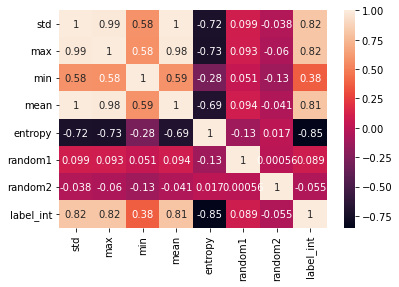

In [30]:
%matplotlib inline
seaborn.heatmap(local.corr(), annot = True)

What is important to note is that in terms of our label, nothing even comes to 90% correlation. We need a more complex model than picking breaths b.y one parameter. Hence machine learning (ML) to the rescue

## ML

You can pick more than one feature with the shift key

In [31]:
features = widgets.SelectMultiple(
    options=['std','max', 'min', 'mean', 'entropy', 'random1', 'random2'],
    value=['min'],
    #rows=10,
    description='Features',
    disabled=False
)
features

SelectMultiple(description='Features', index=(2,), options=('std', 'max', 'min', 'mean', 'entropy', 'random1',…

In [49]:
features_list = list(features.value)
features_list

['mean', 'entropy']

In [50]:
X = csv_to.drop('label', axis =1)
X = X[features_list].values
X = X.astype('float')

In [51]:
len(X)

105

In [52]:
y = csv_to['label'].values
y=y.astype('int')

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
# scale
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [55]:
svm = SVC(kernel= 'linear', random_state=1, C=0.1)
svm.fit(X_train, y_train)

SVC(C=0.1, kernel='linear', random_state=1)

In [56]:
y_pred = svm.predict(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 1.000


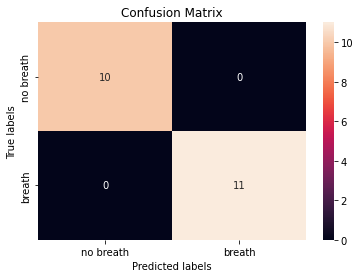

In [57]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
seaborn.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['no breath', 'breath']); ax.yaxis.set_ticklabels(['no breath', 'breath']);

In [58]:
lr = LogisticRegression(solver='liblinear', random_state=0)
lr.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [59]:
y_pred = lr.predict(X_test)

In [60]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 1.000


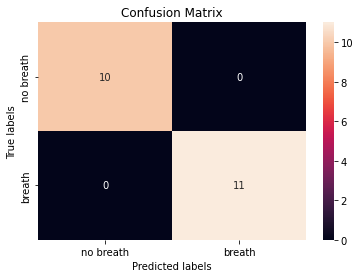

In [61]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
seaborn.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['no breath', 'breath']); ax.yaxis.set_ticklabels(['no breath', 'breath']);

In [62]:
dt = tree.DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [63]:
y_pred = dt.predict(X_test)

In [64]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 1.000


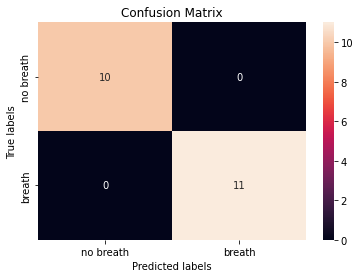

In [65]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
seaborn.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['no breath', 'breath']); ax.yaxis.set_ticklabels(['no breath', 'breath']);

OK, OK, a model with only max and entropy works 100%. This makes sense. Breaths are taller and more entropic..by our definition. What we would need to do is cut the breaths by expert hand, include some edge cases, then run this ML over that (potentially different) dataset. ALso remember we only had a few features in our dataset, of about 100 samples. What we can do it add 3X on data and features, with and without entropy. Will discuss with scientists exactly what features they want.